<a href="https://colab.research.google.com/github/Eugeneantientropy/ML100Days/blob/main/HW_Day_89.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

請參考範例程式碼Day089_CustomizedLoss.ipynb，請自行定義一個 loss function, 為 0.3 * focal loss + 0.7 cross-entropy，訓練並比較結果 (請讓比例為可以隨意調控，而非寫死)



In [9]:
import os
import keras

In [10]:
train, test = keras.datasets.cifar10.load_data()

In [11]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y

In [12]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)


In [13]:
from keras.layers import BatchNormalization

"""
建立神經網路，並加入 BN layer
"""
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)

    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units,
                                   activation="relu",
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units,
                                   activation="relu",
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)

    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)

    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [14]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 1024
MOMENTUM = 0.95

In [15]:
import tensorflow as tf
import keras.backend as K

"""
# 撰寫自定義的 loss function: focal loss (https://blog.csdn.net/u014380165/article/details/77019084)

撰寫重點：
1. Loss function 是探討真實值與預測值的差異，因此自定義 Loss function 時務必要同時輸入真實值與預測值
2. 在 tensorflow 中的運算都是以 tensor 的資料型態進行，因此在輸出 Loss 值時務必要轉成 tensor 資料型態

"""
def focal_loss(gamma=2., alpha=4.):
    gamma = float(gamma)
    alpha = float(alpha)
    def focal_loss_fixed(y_true, y_pred):
        """Focal loss for multi-classification
        FL(p_t)=-alpha(1-p_t)^{gamma}ln(p_t)
        """
        epsilon = 1e-8
        y_true = tf.convert_to_tensor(y_true, tf.float32)
        y_pred = tf.convert_to_tensor(y_pred, tf.float32)

        model_out = tf.add(y_pred, epsilon)
        ce = tf.multiply(y_true, -tf.math.log(model_out))
        weight = tf.multiply(y_true, tf.pow(tf.subtract(1., model_out), gamma))
        fl = tf.multiply(alpha, tf.multiply(weight, ce))
        reduced_fl = tf.reduce_max(fl, axis=1)
        return tf.reduce_mean(reduced_fl)
    return focal_loss_fixed


def combined_loss(gamma=2.0, alpha=4.0, focal_weight=0.3, ce_weight=0.7):
    """ 組合損失函數: 0.3 * Focal Loss + 0.7 * Cross-Entropy """
    focal_loss_fn = focal_loss(gamma, alpha)

    def loss(y_true, y_pred):
        epsilon = 1e-8  # 防止 log(0)
        ce_loss = tf.reduce_sum(y_true * -tf.math.log(y_pred), axis=-1) # Changed tf.log to tf.math.log

        # 計算 Cross-Entropy Loss
        ce_loss = tf.reduce_sum(y_true * -tf.math.log(y_pred), axis=-1)

        # 計算 Focal Loss
        focal_loss_value = focal_loss_fn(y_true, y_pred)

        # 組合 Loss
        total_loss = focal_weight * focal_loss_value + ce_weight * ce_loss
        return tf.reduce_mean(total_loss)

    return loss

In [16]:
model = build_mlp(input_shape=x_train.shape[1:])
model.summary()
optimizer = keras.optimizers.SGD(learning_rate=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
"""
# 在 compile 時，使用自定義的 loss function
"""

f1_score = tf.keras.metrics.F1Score(average="macro")
model.compile(loss=combined_loss(), metrics=["accuracy", f1_score], optimizer=optimizer)

model.fit(x_train, y_train,
          epochs=EPOCHS,
          batch_size=BATCH_SIZE,
          validation_data=(x_test, y_test),
          shuffle=True
         )

# Collect results
train_loss = model.history.history["loss"]
valid_loss = model.history.history["val_loss"]
train_acc = model.history.history["accuracy"]
valid_acc = model.history.history["val_accuracy"]

val_f1_score = model.history.history['val_f1_score']

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 3072)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ hidden_layer1 (Dense)                │ (None, 512)                 │       1,573,376 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ hidden_layer2 (Dense)                │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ hidden_layer3 (Dense)                │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output (Dense)                       │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,742,474 (6.65 MB)

 Trainable params: 1,740,682 (6.64 MB)

 Non-trainable params: 1,792 (7.00 KB)

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 3072))
  warnings.warn(msg)


49/49 ━━━━━━━━━━━━━━━━━━━━ 9s 97ms/step - accuracy: 0.2379 - f1_score: 0.2331 - loss: 4.0241 - val_accuracy: 0.2259 - val_f1_score: 0.1908 - val_loss: 3.4626
Epoch 2/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.4110 - f1_score: 0.4082 - loss: 2.6259 - val_accuracy: 0.3118 - val_f1_score: 0.2896 - val_loss: 3.0953
Epoch 3/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.4529 - f1_score: 0.4500 - loss: 2.3867 - val_accuracy: 0.3810 - val_f1_score: 0.3709 - val_loss: 2.7856
Epoch 4/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.4826 - f1_score: 0.4791 - loss: 2.2345 - val_accuracy: 0.4152 - val_f1_score: 0.4069 - val_loss: 2.5774
Epoch 5/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.5030 - f1_score: 0.5000 - loss: 2.1410 - val_accuracy: 0.4344 - val_f1_score: 0.4314 - val_loss: 2.4546
Epoch 6/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.5199 - f1_score: 0.5172 - loss: 2.0504 - val_accuracy: 0.4491 - val_f1_score: 0.4452 - val_loss: 2.38

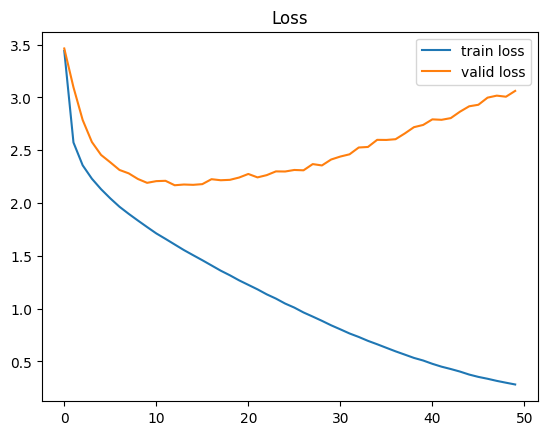

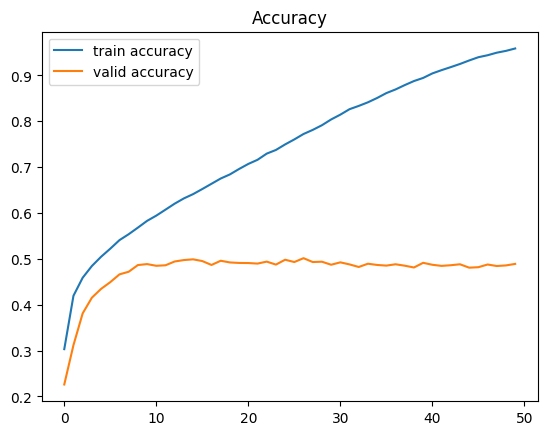

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(range(len(train_loss)), train_loss, label="train loss")
plt.plot(range(len(valid_loss)), valid_loss, label="valid loss")
plt.legend()
plt.title("Loss")
plt.show()

plt.plot(range(len(train_acc)), train_acc, label="train accuracy")
plt.plot(range(len(valid_acc)), valid_acc, label="valid accuracy")
plt.legend()
plt.title("Accuracy")
plt.show()